<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 7: Model Selection </h2>
<br>


The tutorial on linear regression and k-Nearest Neighbours left us with two important questions: how many neighbours should we use in the kNN method? What should be our final model? In this lesson we use cross-validation to address these questions. 

<a href="#1.-Credit-card-data">Credit card data</a> <br>
<a href="#2.-Cross-validation">Cross-validation</a> <br>
<a href="#3.-Hyperparameter-optimisation">Hyperparameter optimisation</a> <br>
<a href="#4.-Feature-selection">Feature selection</a> <br>
<a href="#5.-Model-stacking">Model stacking</a> <br>
<a href="#6.-Evaluation">Evaluation</a> <br>
<a href="#7.-Further tasks">Further tasks</a> <br>

This notebook relies on the following imports and settings. We will load new functions and libraries in context to make clear what we are using them for. 

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [4]:
# Learning algorithms
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Scaler
from sklearn.preprocessing import StandardScaler

## 1. Credit Card Data

We again use the `Credit` dataset. Here we simply repeat the steps from the previous notebook to load and process the data. 

In [5]:
train=pd.read_hdf('Data/Credit.h5', 'train')
test=pd.read_hdf('Data/Credit.h5', 'test')
train.head(5) 

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,
400,18.701,5524,5,64,7,0,0,966,0,0,1
26,14.090,4323,5,25,16,0,1,671,0,0,0
280,54.319,3063,3,59,8,1,0,269,0,1,0
261,67.937,5184,4,63,12,0,1,345,1,0,1
131,23.793,3821,4,56,12,1,1,868,0,0,0


We'll initially consider two predictors for illustrative purposes, the credit card limit and income. 

In [6]:
# Response label
response = 'Balance'

# Response vectors 
y_train = train[response]
y_test = test[response]

## 2. Cross-validation

As our first illustration, let's consider the choice of the number of neighbours in the kNN method. We use [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) to estimate the generalisation performance of the learning algorithm for different values of the hyperparameter.

For purposes of this section, we'll focus on only two predictors.

In [7]:
predictors = ['Limit', 'Income'] 
X_train = train[predictors] 

<h3 style="padding-bottom: 10px">2.1 K-Fold Cross-Validation</h3>

#### 2.1.1 Syntax

The [<TT>cross_val_score</TT>](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from Scikit-Learn allows to compute the cross-validation error of a model.

In [8]:
# Warning! This implementation assumes that the training rows are shuffled.  
# Our train-test split already did that 

from sklearn.model_selection import cross_val_score

knn = KNeighborsRegressor(n_neighbors=10, metric='mahalanobis', metric_params={'V': X_train.cov()})
scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
scores

array([-46938.3375    , -13504.56482143, -18188.13589286, -39258.8625    ,
       -13452.49964286])

The `cv=5` option specifies the number of folds, while `scoring = 'neg_mean_squared_error'` specifies the evaluation criterion. The function returns the score for each fold. Below, we average the scores and obtain the cross-validation root mean squared error. 

In [9]:
rmse = np.sqrt(-1*np.mean(scores))
print(rmse)

162.0755381648587


The scoring in Scikit-Learn follows the convention that higher score values are better. This is why the argument in the function is the negative mean squared error.  The scikit-learn [model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) documentation provides a list of scoring options. It is useful to bookmark it for future reference. 

Often, the syntax is simplified by the fact that each method in scikit-learn has a default scoring method. In this case you have to consult the documentation to know what it is. For a [kNN regression](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) the default scoring is the r-squared.


#### 2.1.2 Plotting the cross-validation error

Let's apply what you've just learned plot the cross validation error as a function of the number of neighbours. 

In [10]:
# Compute the CV error for k=1 to k=50
ks=np.arange(1, 51)
cv_errors = []
for k in ks: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_errors.append(rmse)

# Make figure 
fig = px.line(x=ks, y=cv_errors, # everything below is detail
              labels={'x': 'k', 'y': 'RMSE'}, 
              template='plotly_white',
              color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title='Number of neighbours', yaxis_title='Cross-validation RMSE', )
fig.update_layout(width=800, height=500)
fig.show()

Using `k=6` neighbours leads to the lowest cross-validation error, but there are several other values between `k=5` and `k=11` lead to very similar performance.  

### 2.2 Repeated K-Fold

Because the size of the training data is not large, there is high variation in the MSE across folds. In turn, this indicates that the cross-validation error has large variance. In this case, it can be useful to use repeated k-fold to reduce the variance, at the cost of additional computational time.

<h4 style="padding-top: 20px">2.2.1 Syntax</h4>

For this method we have to instantiate the cross-validation method separately. 

In [11]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=100)

knn = KNeighborsRegressor(n_neighbors=10, metric='mahalanobis', metric_params={'V': X_train.cov()})
scores = cross_val_score(knn, X_train, y_train, cv = rkf, scoring = 'neg_mean_squared_error')
np.sqrt(-1*np.mean(scores))  # five folds times ten repeats

158.11598563803003

#### 2.2.2 Plotting the cross-validation error

This next cell will be slower to run. 

In [12]:
# Compute the CV error for k=1 to k=50
ks=np.arange(1, 51)
cv_errors = []
for k in ks: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_errors.append(rmse)

# Make figure 
fig = px.line(x=ks, y=cv_errors, 
              labels={'x': 'k', 'y': 'RMSE'}, 
              template='plotly_white',
              color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title='Number of neighbours', yaxis_title='Cross-validation RMSE', )
fig.update_layout(width=800, height=500)
fig.show()

The curve now looks much smoother, which suggests that repeated k-fold worked to reduced the variance. We still select `k=6`, but the choice now seems more reliable. 

**Warning!** Repeated k-fold is strictly better statistically but becomes very slow for larger datasets and more complex methods.

## 3. Hyperparameter optimisation

What we did in the last section was a manual grid search for `k` with an added visualisation. Now, let's see how we can automate this process. 

In [13]:
from sklearn.model_selection import GridSearchCV
 
# Learning algorithm
model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': X_train.cov()}) 

# Hyperparameter grid
param_grid = {'n_neighbors': np.arange(1,51),}

# Run the grid search (cv=5 would do 5-fold CV instead)
knn_search =  GridSearchCV(model, param_grid, cv = rkf,  scoring = 'neg_mean_squared_error',  n_jobs=4)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=100),
             estimator=KNeighborsRegressor(metric='mahalanobis',
                                           metric_params={'V':                Limit        Income
Limit   5.492703e+06  64999.556494
Income  6.499956e+04   1210.189671}),
             n_jobs=4,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='neg_mean_squared_error')

Setting `n_jobs=4` splits the task across four processor cores, which speeds up the computations. You may need to reduce this depending on your computer.

The `best_params_` attribute allows us view the selected value of the hyperparameter.  

In [14]:
knn_search.best_params_

{'n_neighbors': 6}

The selected model is stored in the `best_estimator_` attribute: 

In [15]:
knn_search.best_estimator_

KNeighborsRegressor(metric='mahalanobis',
                    metric_params={'V':                Limit        Income
Limit   5.492703e+06  64999.556494
Income  6.499956e+04   1210.189671},
                    n_neighbors=6)

## 4. Feature selection

Now, let's look at how we can select the features. 

In [16]:
predictors = [x for x in train.columns if x != response]
print(predictors)

['Income', 'Limit', 'Cards', 'Age', 'Education', 'Student', 'Married', 'Male', 'Caucasian', 'Asian']


### 4.1 Forward selection

This next cell uses the forward selection method discussed in the lecture to choose the features for linear regression. Using the r-squared gives the same result as the MSE. 

In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

fwd = SFS(LinearRegression(), k_features='best', forward=True, cv=5, scoring='neg_mean_squared_error')
fwd.fit(train[predictors], y_train)
subset_ols = fwd.k_feature_idx_ # we need the numerical indexes for later
print(fwd.k_feature_names_)

('Income', 'Limit', 'Cards', 'Student')


The cross-validation performance is stable for a number of features larger than three.

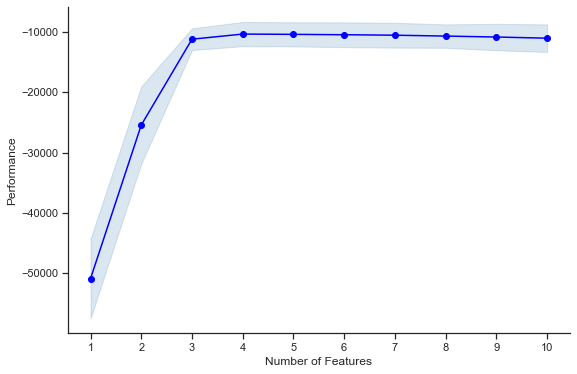

In [18]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(fwd.get_metric_dict(), kind='std_dev') # The metric is the prediction R-squared by default
sns.despine()
plt.show()

The dimensionality of our problem is small enough that we could actually do an exhaustive search (trying all feature combinations) in this case. However, this method is generally not computationally feasible.

In [19]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

bss = ExhaustiveFeatureSelector(LinearRegression(), max_features=10, cv=5, scoring='neg_mean_squared_error')
bss.fit(train[predictors], y_train)
bss.best_feature_names_

Features: 1023/1023

('Income', 'Limit', 'Cards', 'Student')

Unfortunately, doing forward selection for kNN would require very advanced coding because of the metric parameters and the choice of `k`. The result is the choice of predictors below with `k=3`. 

In [20]:
subset_knn = [0, 1, 5]  # Income, Limit, Student

### 4.2 Column selector

For practical reasons, it's often useful if we can pass the same `X_train` for all methods, even if they use different features. We use a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html?highlight=pipeline#sklearn.pipeline.make_pipeline) to combine a sequence of data processing steps with a learning algorithm.

In [21]:
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector

ols = make_pipeline(ColumnSelector(cols=subset_ols),
                    StandardScaler(), # just for illustration
                    LinearRegression())
ols.fit(train[predictors], y_train)

Pipeline(steps=[('columnselector', ColumnSelector(cols=[0, 1, 2, 5])),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

For kNN:

In [22]:
knn = make_pipeline(ColumnSelector(cols=subset_knn),
                    KNeighborsRegressor(n_neighbors=3, metric='mahalanobis', 
                                        metric_params={'V': train.iloc[:, subset_knn].cov()}))
knn.fit(train[predictors], y_train)

Pipeline(steps=[('columnselector', ColumnSelector(cols=[0, 1, 5])),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='mahalanobis',
                                     metric_params={'V':                Income         Limit    Student
Income    1210.189671  6.499956e+04  -0.226186
Limit    64999.556494  5.492703e+06 -30.519713
Student     -0.226186 -3.051971e+01   0.081605},
                                     n_neighbors=3))])

### 4.3 Note

Subset selection is one way to avoid overfitting in the number the features. It has the disadvantage of large computational cost. Regularisation is more common but not always applicable. 

 ## 5. Model stacking
 
From the lecture, the recommended approach for selecting the final model is to fit a model average and perhaps consider a more complex model stack. A model average is a special case of a model stack and always a great place to start because we can interpret the weights.

### 5.1 Standard analysis

We use the [StackingCVRegressor](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.regressor/#stackingcvregressor) method from the `mlxtend` package. We use a linear regression as the meta-model, which essentially does a model average.

In [23]:
%%capture 

from mlxtend.regressor import StackingCVRegressor
 
stack = StackingCVRegressor(regressors=[ols,knn], meta_regressor=LinearRegression(), 
                           cv=5, random_state=10, store_train_meta_features=True)
stack.fit(train[predictors], y_train)

Let's check the model weights. They do not sum to one exactly since we do not restrict them, but we can interpret them as saying that meta-model gives about 72% weight to kNN and 28% weight to linear regression.  

In [24]:
stack.meta_regr_.coef_

array([0.30681792, 0.73316533])

It's also very useful to check how the model stack compares to the individual models. 

In [25]:
from sklearn.model_selection import cross_val_predict

# Initialise table
columns=['CV RMSE', 'CV R-Squared', 'CV MAE']
rows=['Linear Regression', 'kNN', 'Stack']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Get CV predictions
y_pred = np.zeros((len(y_train), 4)) # initialising a matrix to store the predictions (one extra on purpose)
y_pred[:,:2] = stack.train_meta_features_
y_pred[:, 2] = stack.predict(train[predictors])
# Fill table with the results
for i in range(3):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_train, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred[:,i])

results.round(2)

,CV RMSE,CV R-Squared,CV MAE
Linear Regression,102.63,0.95,81.67
kNN,76.00,0.97,49.11
Stack,49.31,0.99,37.71


This model stack is very good! 

It's important to understand what's happening statistically. If we compute the correlation between the prediction errors from kNN and linear regression, it's quite weak in this case. In this situation, a model average is very effective for reducing variance, identically to diversification in finance.  

In [26]:
np.corrcoef((y_train.to_numpy().reshape((-1,1))-y_pred[:,:2]).T)

array([[1.        , 0.25482234],
       [0.25482234, 1.        ]])

### 5.2 Adjusted predictions

We can do even better because of the issue that the linear regression model generates negative predictions that are inconsistent with the range of the response.  Ideally, we should use a model that does not do that in the first place. Nevertheless, we should always make the most out of the tools that we currently have. 

The disadvantage is that we have to fit the stack and make adjustments manually if we want to avoid coding that is too advanced. 

In [27]:
# Initialise table
rows=['Linear Regression', 'kNN', 'Stack', 'Stack (adjusted)']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Adjustment in the linear regression predictions
y_pred[y_pred[:, 0]<0, 0] = 0

# New stack
adjstack = LinearRegression().fit(y_pred[:,:2], y_train)
y_pred[:, 3] = adjstack.predict(y_pred[:,:2])
y_pred[y_pred[:, 3]<0, 3] = 0

# Fill table with the results
for i in range(4):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_train, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred[:,i])

results.round(2)

,CV RMSE,CV R-Squared,CV MAE
Linear Regression,74.51,0.97,56.54
kNN,76.00,0.97,49.11
Stack,49.31,0.99,37.71
Stack (adjusted),40.54,0.99,27.67


Now it's the linear regression model that gets more weight. 

In [28]:
adjstack.coef_

array([0.76522707, 0.32917987])

### 5.3 Final model

Before evaluation, it's essential that we identify what the final model is. Based on the above results, we select the adjusted stack. Even though we will show test results for other models, they are only for benchmarking and discussion.

## 6. Evaluation
 
The key point in this tutorial is that everything that we did to arrive at the final model (hyperparameter optimisation, feature selection, and model stacking) was based exclusively on the training data. If model selection works well, the choices that minimise the cross-validation error should approximately be the choices that minimise the risk. 

In evaluation, we estimate the risk of the final model to evaluate whether its generalisation performance achieves the objectives of the machine learning project. In practice, these are business objectives that may require achieving a certain test RMSE or reducing the risk by a certain amount relative a benchmark. 

Since the objective of this project is learning, we take a linear regression based on all the predictors as a benchmark, which was our starting point in this unit.  

The main test results are: 

1. We obtain a large reduction in the risk relative to the benchmark, which achieves the learning goals. For a large final institution, even small improvements in the risk can translate into hundreds of thousands or millions of dollars in business value. 

2. The final model performs very well relative to other models, just as the cross-validation results suggested. 

3.  The test set RMSE is similar to the cross-validation RMSE, which reassures us that the final model did not significantly overfit the training data. 

In [29]:
# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Benchmark', 'Linear Regression', 'kNN', 'Stack', 'Final model (adjusted stack)']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# Benchmark
benchmark = LinearRegression().fit(train[predictors], y_train)

# Methods
methods=[benchmark, ols, knn, stack]

# Compute test predictions
y_pred = np.zeros((len(y_test), 5))
for i, method in enumerate(methods):
    y_pred[:, i] = method.predict(test[predictors])
    
# adjusted method
y_pred[y_pred[:, 1]<0, 1] = 0
y_pred[:, 4] = adjstack.predict(y_pred[:,1:3])
y_pred[y_pred[:, 4]<0, 4] = 0

# Test results
for i in range(5):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_test, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred[:,i])

results.round(2)

,RMSE,R-Squared,MAE
Benchmark,97.19,0.96,80.03
Linear Regression,78.42,0.97,62.06
kNN,81.15,0.97,49.34
Stack,68.30,0.98,49.95
Final model (adjusted stack),44.33,0.99,31.63


We've come a long way with this data! This application illustrates that there's a lot that we can discover and do even with a small dataset. 

## 7.  Further tasks

If you are looking for a challenge, you can try to modify the code to see if you can improve the models through feature engineering. For example, you can try transforming income and limit and investigate possible interactions. 

Transforming the response can eliminate the issue of negative predictions. 

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [30]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:400|Open+Sans:800&display=swap');
</style>

In [31]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')